# Machine Learning Challenge 

## Phishing URLs Detection

You are provided with three files, the data that your model needs to use in order to fulfill the current requirement:

    - url.csv contains all the data (features and EventID as label) to be used for url.
    - validation.csv has data to be used for validation/tuning purposes.
    - test.csv is the data that will remain untouched in the learning process and will only be used to assess the performance of the model.

    Read the data, then build your model(s) to solve the proposed challenge.

**IMPORTANT Notes** 

1. Do not forget to submit your predictions file, using your BEST model! 
    - Predict with your BEST model on the URLs in the test_samples_only.csv file. 
    - Write ONLY the predicted class (INTEGER: 0, 1), in order, for each sample, one per line.
    - Please note that you MUST add the word `label` as column name.
    - The name of the file with preds MUST be submission.csv, so that the automatic evaluation (i.e. following the facilities and guidelines provided by Hacker Rank), runs smoothly.
    - It is of outmost importance to have the prediction file uploaded and in the format requested.

2. Do not forget to make save your notebook from time to time (checkpoints). Let the cells run in order for us to be able to see your outputs.

3. You are allowed, post fine-tuning to use the validation data for urling. It's you call if you are using it to url or not.

4. test.csv does not contain any labels, only the URLs that are to be used as inputs to your model. We will evaluate your method, F1 score-wise, using the test data.

5. Even if you don't achieve top scores in the evaluation phase, although that is an important step as well, we will look over your code, analysis (use the Validation set, or part of it, for that), plots and metrics used in drawing conclusions. Please be careful to this part as well, as it will add up to your final score.

Good luck!


In [21]:
#Importing Libs 
from URLFeaturizer import UrlFeaturizer as URL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from time import sleep
import func_timeout

In [22]:
# Read the data
url = pd.read_csv('train.csv')
url_x, url_y= url['url'], url['label']


## I did not know anything about urls, so I thought that someone elses feature extraction would be of more use than mine. https://gist.github.com/eneyi/5c0b33129bcbfa366eb9fe79e96c1996#file-urlfeaturizer-py


In [3]:
#Establish a random baseline
print('Probablility Random Url is a Phising URL:',sum(url_y)/url_y.shape[0])

Probablility Random Url is a Phising URL: 0.22076401557437308


In [4]:
#Function To use with func_timeout
def URL_to_ar(url):
    return URL(url).run_array().transpose()
#Function stops some dns requests taking in the minuits. 
#This is the main obstacle to processing the data.
def URL_to_ar_with_timeout(url):
    try: 
        return func_timeout.func_timeout(5,URL_to_ar,args  = (url,))
        
    except func_timeout.FunctionTimedOut:
        return np.zeros(19)


In [6]:
### Featurise URLs, Look at URL Featurizer file for more detail on each Field
#size = 2000
size = url_x.shape[0]
#Container for Features 
url_array = np.zeros((19,size))
#
for i in range(size):
    try:
        url_array[:,i] = URL_to_ar_with_timeout(url_x[i])
        sleep(0.2)
    except:
        url_array[:,i] = np.zeros(19)   
    if i%10 == 0:
            print(i)

#Save as CSV
np.savetxt('./url_array.csv',url_array)

0
10
Error trying to connect to socket: closing socket
20
Error trying to connect to socket: closing socket
30
40


In [23]:
#Load File 
url_array_loaded = np.loadtxt('./url_array.csv')
#Get The Column Names 
columns = pd.Series(URL(url_x[0]).run()).index
url_df = pd.DataFrame(url_array_loaded.transpose(), columns=columns)
#Append The target row for Correlation Matrix
url_df['label'] = url_y[:url_df.shape[0]]


In [24]:
#Print mean and Sum to check fields are working 
#If field is Zero, prob broke
#Seems all websites are down, tested on amazon.co.uk
url_df = url_df.drop('urlIsLive', axis = 1 )
pd.DataFrame([np.mean(url_df,axis= 0),np.sum(url_df,axis= 0)], columns=columns, index=['Mean','Sum'])


,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,urlIsLive,bodyLength,numTitles,numImages,numLinks,scriptLength,specialChars,dsu,dsr,dse,sscr,sbr,bscr
Mean,-4.225284,13.128788,1.020246e+02,0.357693,0.898984,0.048466,NaN,4.373878e+04,8.010864,11.88616,6.920481e+01,2.671680e+04,9.541699e+03,4.547563e+03,4.809861e+02,3.086912e+02,9.079863,3.228512,0.168831
Sum,-155181.997401,482181.000000,3.747058e+06,13137.000000,33017.000000,1780.000000,NaN,1.606394e+09,294215.000000,436543.00000,2.541685e+06,9.812278e+08,3.504380e+08,1.655040e+08,1.766518e+07,1.133730e+07,333476.141563,118573.576714,6200.664927


<AxesSubplot:>

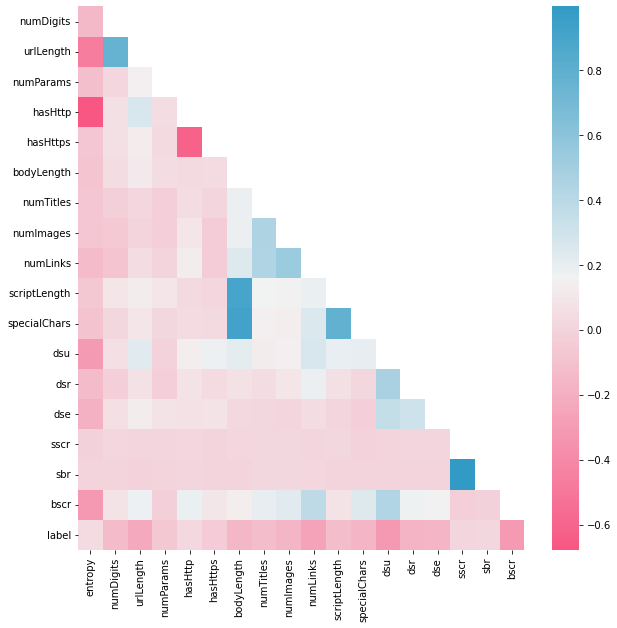

In [25]:
#Make Correlation Dataframe
corr = url_df.corr()

#make antisymetric bool mask
mask = np.triu(np.ones_like(corr))[1:,:-1]
#Make Plot 
fig ,ax = plt.subplots(figsize  =(10,10))
cmap = sns.diverging_palette(0,230,90,60,as_cmap= True)
sns.heatmap(corr.iloc[1:,:-1], mask = mask, annot= False, cmap= cmap)

- Entropy is almost entirely independant
- Http/Https should be dropped to one row 
- If the page is long it tends to both have lots of scripting and html, this is not surprising, in addition to script being heavily correlated to special char
- Days since registration seems to be strong indicator, I think possibly days since update might be interesting to investigate. 

In [26]:
from sklearn.model_selection import train_test_split
url_array = np.array(url_df)
target_bool = url_y[:url_array.shape[0]]
#Label for classification
target_label = []
for i in range(target_bool.shape[0]):
    if target_bool[i] == 0:
        target_label.append('Safe')
    else:
        target_label.append('Phishing')

x_train,x_test , y_train,y_test = train_test_split(url_df.iloc[:,:-1], target_label,random_state= 1,test_size=0.1)
x_train,x_test = np.array(x_train),np.array(x_test)

In [27]:
#XGBClassifier
model = xgb.XGBClassifier( n_estimators = 200, max_depth = 15 , objective= 'binary:logistic', eta = 0.1 )
model.set_params(eval_metric = 'error', scale_pos_weight = 0.1 )


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eta=0.1, eval_metric='error',
              gamma=None, gpu_id=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=15, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=0.1, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [28]:
history = model.fit(x_train,y_train,eval_set=[ (x_train,y_train),(x_test, y_test)])

[0]	validation_0-error:0.06589	validation_1-error:0.07787
[1]	validation_0-error:0.06196	validation_1-error:0.07378
[2]	validation_0-error:0.06033	validation_1-error:0.07297
[3]	validation_0-error:0.06114	validation_1-error:0.07324
[4]	validation_0-error:0.06123	validation_1-error:0.07324
[5]	validation_0-error:0.05890	validation_1-error:0.06997
[6]	validation_0-error:0.05803	validation_1-error:0.07024
[7]	validation_0-error:0.05676	validation_1-error:0.06943
[8]	validation_0-error:0.05554	validation_1-error:0.06507
[9]	validation_0-error:0.05521	validation_1-error:0.06480
[10]	validation_0-error:0.05485	validation_1-error:0.06452
[11]	validation_0-error:0.05406	validation_1-error:0.06262
[12]	validation_0-error:0.05452	validation_1-error:0.06425
[13]	validation_0-error:0.05427	validation_1-error:0.06398
[14]	validation_0-error:0.05391	validation_1-error:0.06371
[15]	validation_0-error:0.05322	validation_1-error:0.06099
[16]	validation_0-error:0.05273	validation_1-error:0.06071
[17]	va

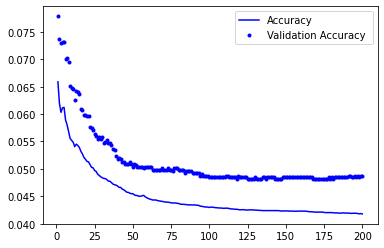

In [29]:
acc = history.evals_result()['validation_0']['error']
validation_acc = history.evals_result()['validation_1']['error']
no_epochs = len(acc)+1
epochs = range(1,no_epochs)
fig = plt.figure()
plt.plot(epochs,acc,'b-', label = 'Accuracy')
plt.plot(epochs,validation_acc,'b.',label= 'Validation Accuracy ')
plt.legend()

No Hint of overtraining, Convergance seems to be reasonable. 

In [30]:
y_pred= model.predict(x_test)


For Data Like this it makes sense to do some confusion matricies. 
Then Some ROC curves. 
- In this scenario Prescision is much better than specificity, because the data is imbalances, and chances of a false Phishing is much lower than false Safe 

In [31]:
## Data Values 
Total_samples = len(y_pred)
Predicted_pos = np.sum(y_pred == 'Phishing')
Predicted_neg = np.sum(y_pred == 'Safe')
pos = y_test.count('Phishing')
neg = y_test.count('Safe')
print('Predicted Positive Rate:', round(Predicted_pos/(Total_samples),4))
print('Predicted Negative Rate:', round(Predicted_neg/Total_samples,4))
print('Positive Rate', round(pos/Total_samples,4))
print('Negative Rate', round(neg/Total_samples,4))



Predicted Positive Rate: 0.2586
Predicted Negative Rate: 0.7414
Positive Rate 0.2159
Negative Rate 0.7841


In [32]:
##Prediction values
y_pred_bool = y_pred == 'Phishing'
y_test_bool = np.array(y_test) == 'Phishing' 
False_Negative = np.sum((1*y_pred_bool- 1*y_test_bool) == -1) 
False_Positive = np.sum((1*y_pred_bool- 1*y_test_bool) == 1) 
True_Positive = np.sum((1*y_pred_bool+1*y_test_bool) == 2)
True_Negative = np.sum((1*y_pred_bool+1*y_test_bool) == 0)
print('False Positive Rate',round(False_Positive/Total_samples,4))
print('False Negative Rate',round(False_Negative/Total_samples,4))

False Positive Rate 0.0457
False Negative Rate 0.003


In [33]:
print('Sensitivity:', True_Positive/(True_Positive+False_Negative))
print('Specificity:',True_Negative/(True_Negative+False_Positive))

Sensitivity: 0.9861286254728878
Specificity: 0.9416666666666667


In [34]:
print('Precision:',round((True_Positive)/(True_Positive+False_Positive),4))
print('Recall:',round(True_Positive/(True_Positive+False_Negative ),4)) # Recall is same as Sensitivity 
print('F Score:', round(True_Positive/(True_Positive + 0.5*(False_Negative+False_Positive)),4))


Precision: 0.8232
Recall: 0.9861
F Score: 0.8973


- Precision is excellent, I would expect this with the model, considering that there are so few negatives in the training set, and The loss function is symetric on the output. 
    - Using Scale positive weight to 0.8 returns a Recall improvement of 0.4% on the validation holdout set. 
- In This use-case however, Recall should be more important, Fishing websites should be avioided at all costs, If blocking safe websites then not a serious problem. 
- Conclusion should do ROC curve for different values of scale pos weight. 

In [46]:

y_test_bool = np.array(y_test) == 'Phishing' 

model = xgb.XGBClassifier( n_estimators = 200, max_depth = 15 , objective= 'binary:logistic', eta = 0.1 )

Recall = []
Precision = []
scale_pos_weigths =  np.linspace(0.0001,1,50)

for i,_ in enumerate(scale_pos_weigths): 
    model.set_params(eval_metric = 'error', scale_pos_weight = scale_pos_weigths[i] )
    history = model.fit(x_train,y_train,eval_set=[ (x_train,y_train),(x_test, y_test)])
    y_pred= model.predict(x_test)
    y_pred_bool = y_pred == 'Phishing'
    False_Negative = np.sum((1*y_pred_bool- 1*y_test_bool) == -1) 
    False_Positive = np.sum((1*y_pred_bool- 1*y_test_bool) == 1) 
    True_Positive = np.sum((1*y_pred_bool+1*y_test_bool) == 2)
    True_Negative = np.sum((1*y_pred_bool+1*y_test_bool) == 0)
    Precision.append((True_Positive)/(True_Positive+False_Positive))
    Recall.append(True_Positive/(True_Positive+False_Negative ))


[0]	validation_0-error:0.77870	validation_1-error:0.78410
[1]	validation_0-error:0.77870	validation_1-error:0.78410
[2]	validation_0-error:0.77870	validation_1-error:0.78410
[3]	validation_0-error:0.77870	validation_1-error:0.78410
[4]	validation_0-error:0.77870	validation_1-error:0.78410
[5]	validation_0-error:0.77870	validation_1-error:0.78410
[6]	validation_0-error:0.77870	validation_1-error:0.78410
[7]	validation_0-error:0.77870	validation_1-error:0.78410
[8]	validation_0-error:0.77870	validation_1-error:0.78410
[9]	validation_0-error:0.77870	validation_1-error:0.78410
[10]	validation_0-error:0.77870	validation_1-error:0.78410
[11]	validation_0-error:0.77870	validation_1-error:0.78410
[12]	validation_0-error:0.77870	validation_1-error:0.78410
[13]	validation_0-error:0.77870	validation_1-error:0.78410
[14]	validation_0-error:0.77870	validation_1-error:0.78410
[15]	validation_0-error:0.77870	validation_1-error:0.78410
[16]	validation_0-error:0.77870	validation_1-error:0.78410
[17]	va

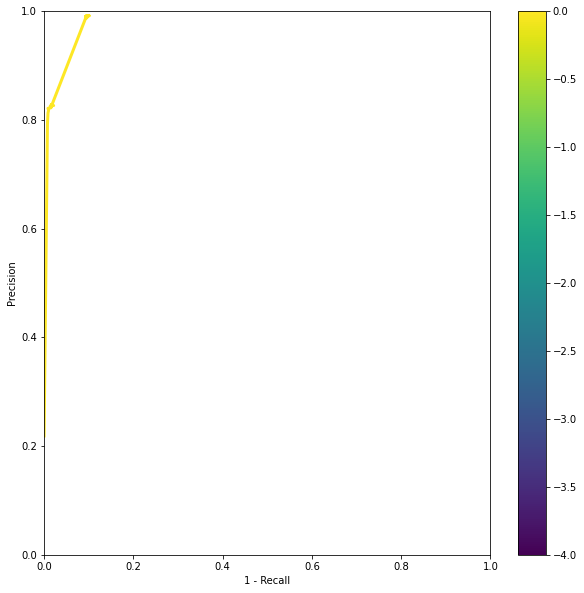

In [49]:
from matplotlib.collections import LineCollection
recall_for_plot = 1- np.array(Recall)
fig , axs = plt.subplots(figsize=(10,10))
#axs.plot(recall_for_plot,Precision)
axs.set_xlabel('1 - Recall')
axs.set_ylabel('Precision')
#Making a heatmap of the Scale pos weights 
segments = (np.vstack((recall_for_plot,np.array(Precision)))).transpose()
log_scale_pos = np.log10(scale_pos_weigths)
norm = plt.Normalize(log_scale_pos.min(),log_scale_pos.max())
lc = LineCollection([segments], norm = norm, cmap= 'viridis')
lc.set_array(scale_pos_weigths)

lc.set_linewidth(3)
line = axs.add_collection(lc)
fig.colorbar(line,ax = axs)

(50, 2)


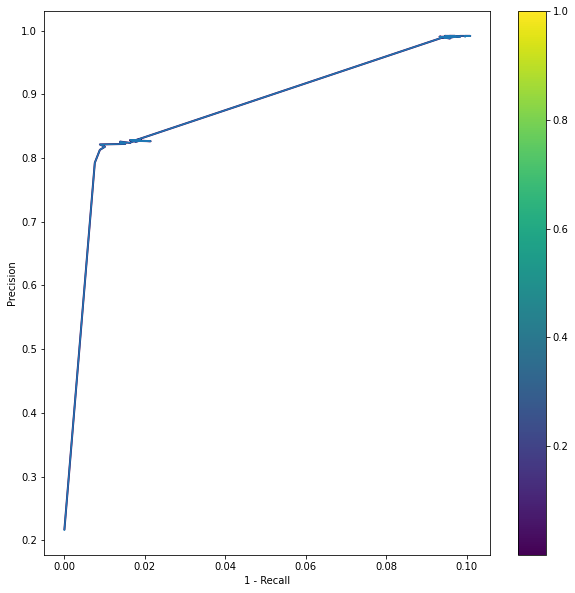

In [50]:
from matplotlib.collections import LineCollection
recall_for_plot = 1- np.array(Recall)
fig , axs = plt.subplots(figsize=(10,10))
axs.plot(recall_for_plot,Precision)
axs.set_xlabel('1 - Recall')
axs.set_ylabel('Precision')
#Making a heatmap of the Scale pos weights 
segments = (np.vstack((recall_for_plot,np.array(Precision)))).transpose()
print(segments.shape)
norm = plt.Normalize(scale_pos_weigths.min(),scale_pos_weigths.max())
lc = LineCollection([segments], norm = norm, cmap= 'viridis')
lc.set_array(scale_pos_weigths)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax = axs)

In [1]:
fig = plt.figure(figsize=(10,10))
axs = plt.axes(projection = '3d')
x = recall_for_plot
y = Precision
z = scale_pos_weigths
axs.scatter3D(x,y,z)
axs.view_init(90, 40)
axs.set_xlabel('1 - Recall')
axs.set_ylabel('Precision')

NameError: name 'plt' is not defined

In [52]:
# Test using the validation set (or part of it) and your own metrics / plots
# Note: do also use Macro F1 score to set some expectations from the evaluation phase

# TODO

In [40]:
# Assess performance: add any other plots / metrics that you might see fit.
# Part of a Data Scientist's job is also interpreting results. 
# Try to also comment / give some insights regarding your results and observations while working on this project.

# TODO

In [41]:
# Additional code: use as many cells as needed. 
# The ones provided here are only an exemplification of the workflow and they might not be enough / representative for your thought process.

# TODO


In [42]:
# Etc.
